**Importing Dependencies**

In [1]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
# Probably not needed --> test ray lib instead
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

from Environment.env_v3 import *
from Functions.visualization_functions import *

**Configuration of the Scenario**

In [2]:
# Configuration of the network
# Sample JSON configuration (replace this with your JSON data)
with open('./Config/network_config_v0.json') as file:
    network_config = file.read()

# TODO : Implement configuaration for cost and demand (actual and exptected)

**Building the environment**

In [3]:
EP_LENGTH = 30 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

In [4]:
list(env.graph.nodes())

['A', 'B', 'C', 'D', 'S']

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


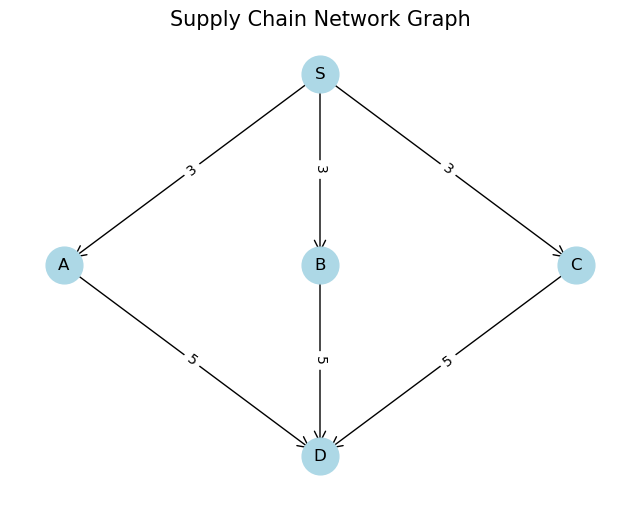

In [5]:
env.render_network()

In [6]:
env.order_queues

{'A': deque([0, 0, 0], maxlen=3),
 'B': deque([0, 0, 0], maxlen=3),
 'C': deque([0, 0, 0], maxlen=3)}

In [7]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(
/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:464: UserWarning: Your action space has dtype int64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(


**Testng the environment**

In [8]:
env.action_history

[]

In [9]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        # print('Step t:{} Score:{} Stock:{} Order:{} Delivered:{} Exp Demand t+3:{} Act Demand:{}'.format((EP_LENGTH - env.episode_length), score, n_state[0], action, env.delivered, n_state[1], env.demand))

        env.render()

    # print(env.order_history)

Episode Length: 1
Stock Level: [21.71531474 28.         32.        ]
Planned Demand: [6.65461513 0.         0.        ]
Actual Demand: [8.28468526 0.         0.        ]
Action: [29 82 29]
Order: [0, 0, 0]
Reward: -40.85765737220012

Episode Length: 2
Stock Level: [ 8.09897676 13.33972789 32.        ]
Planned Demand: [12.00588315 12.05842396  0.        ]
Actual Demand: [13.61633798 14.66027211  0.        ]
Action: [52 93 90]
Order: [0, 0, 0]
Reward: -67.57700970065162

Episode Length: 3
Stock Level: [ 8.09897676 13.33972789 18.21897877]
Planned Demand: [ 0.          0.         10.12119864]
Actual Demand: [ 0.          0.         13.78102123]
Action: [ 4 60 52]
Order: [0, 0, 0]
Reward: -87.40585141214342

Episode Length: 4
Stock Level: [14.73184769 79.68193859 47.21897877]
Planned Demand: [12.81651674  9.4540639   0.        ]
Actual Demand: [22.36712907 15.65778931  0.        ]
Action: [75 19 85]
Order: [29, 82, 29]
Reward: -858.2222339350001

Episode Length: 5
Stock Level: [ 66.7318476

**Train Model**


In [10]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')

In [11]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

env = DummyVecEnv([lambda: env])

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device


In [12]:
model.learn(total_timesteps=10000)

Logging to Training/Logs/PPO_41
-----------------------------
| time/              |      |
|    fps             | 7112 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 3655         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0034096744 |
|    clip_fraction        | 0.0063       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.26        |
|    explained_variance   | 5.01e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.18e+07     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00586     |
|    std                  | 1            |
|    value_loss           |

In [13]:
evaluate_policy(model, env, n_eval_episodes=1, render=True, return_episode_rewards=True)

Episode Length: 1
Stock Level: [30.         28.         24.15004897]
Planned Demand: [0.        0.        7.7451152]
Actual Demand: [0.         0.         7.84995103]
Action: [0.         0.         0.01682113]
Order: [0, 0, 0]
Reward: -41.075024483212204

Episode Length: 2
Stock Level: [22.65718667 11.96200845 24.15004897]
Planned Demand: [10.18350639 13.04002655  0.        ]
Actual Demand: [ 7.34281333 16.03799155  0.        ]
Action: [0.         0.         0.02724086]
Order: [0, 0, 0]
Reward: -70.4596465278335

Episode Length: 3
Stock Level: [22.65718667 11.96200845 24.15004897]
Planned Demand: [0. 0. 0.]
Actual Demand: [0. 0. 0.]
Action: [0.         0.         0.01577569]
Order: [0, 0, 0]
Reward: -99.8442685724548

Episode Length: 4
Stock Level: [13.60183158 11.96200845 24.1668701 ]
Planned Demand: [11.1503305  0.         0.       ]
Actual Demand: [9.0553551 0.        0.       ]
Action: [0.         0.         0.01577569]
Order: [0.0, 0.0, 0.016821132972836494]
Reward: -124.793729299

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


([-10403.189105987549], [30])

In [14]:
df = pd.read_csv('./Data/2024-10-14_17_last_environment_data.csv')

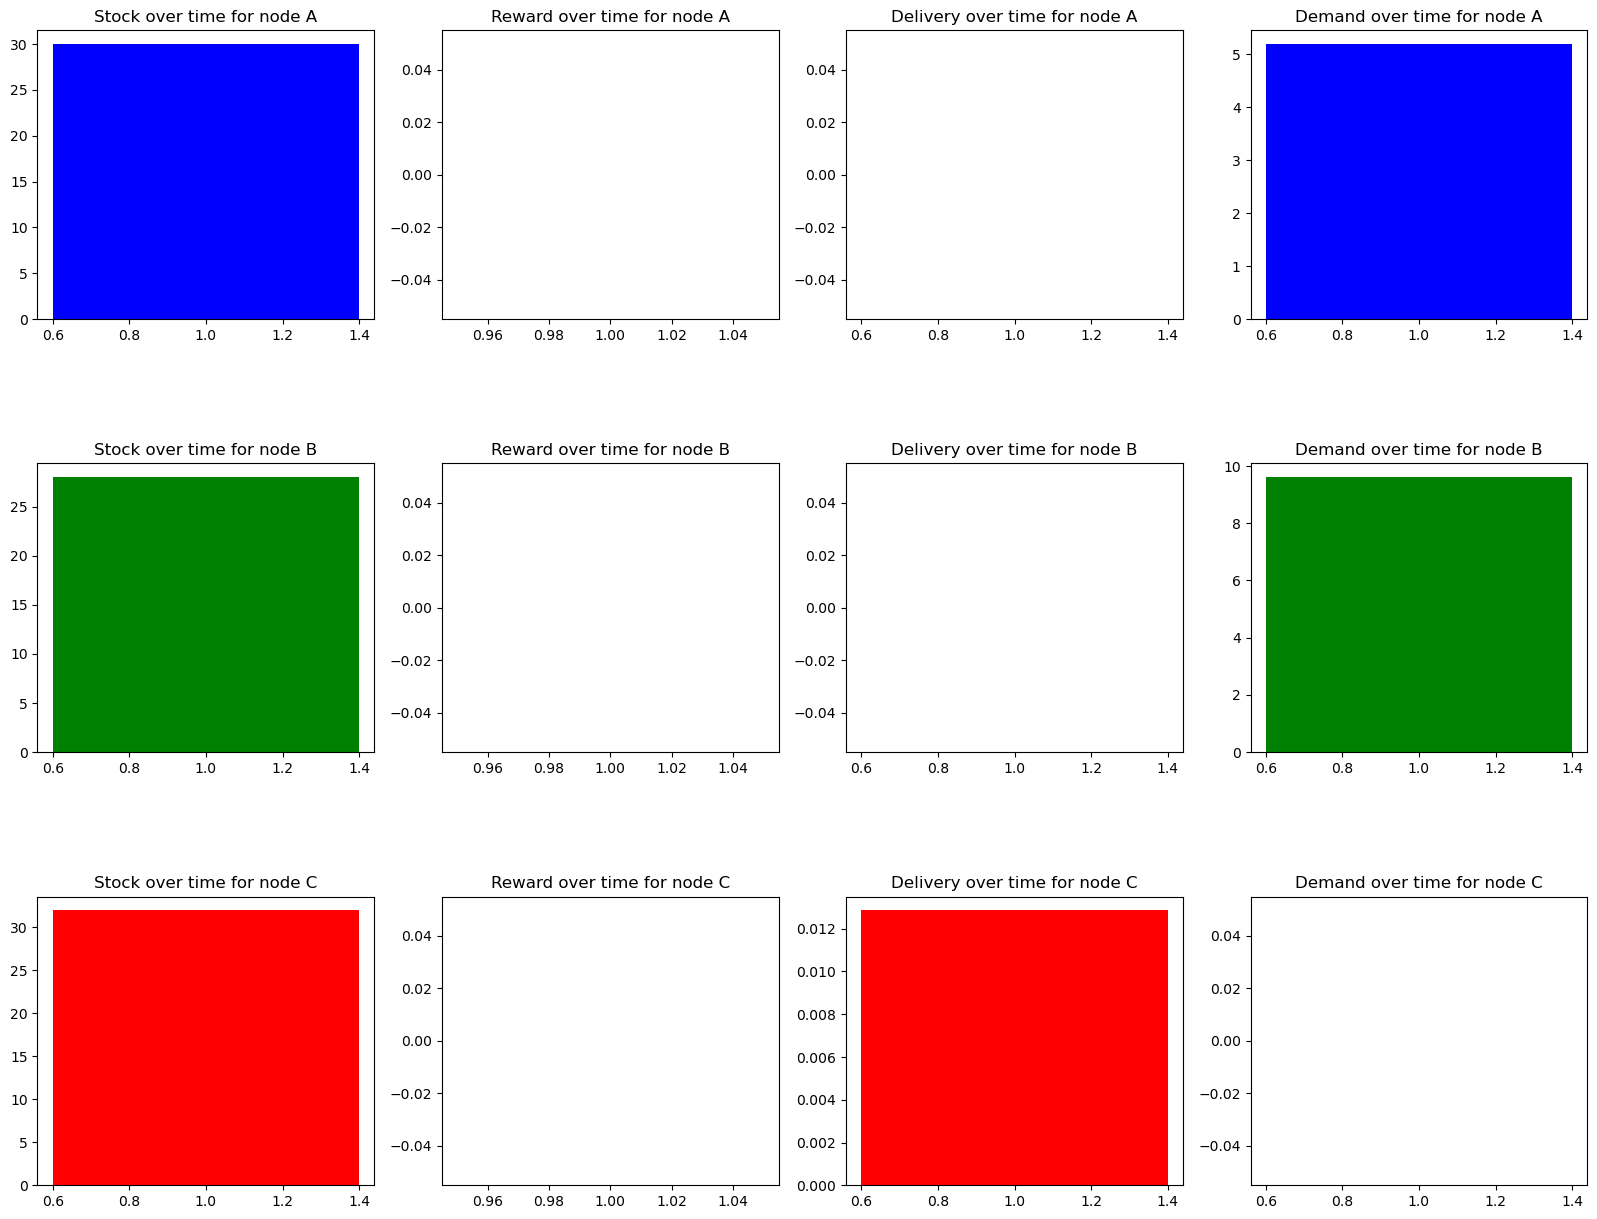

In [15]:
plot_data(df)